Notes from https://arxiv.org/pdf/2411.11269 [1]

https://arxiv.org/pdf/2411.11269 uses Variable Projection to determine the content of the model rather than least squares. They employ VARPO (https://github.com/sxs-collaboration/varpro) at late times to determine the complex amplitudes and frequencies of very long-lived modes (above the noise floor), then step backwards (fixing the frequencies of known modes at later times)

*Things to consider:

- Neglect contribution to null memory
- Adjust the scale of the time coordinate to match the convention in tabulated values 
- Adding a constant term to the superposition to account for an unknown cpt of the ringdown 

____

Higher overtone number amplitudes become unstable at earlier times, even in the presence of an extremely low noise floor. The effect cascades to lower overtone number in part due to the higher modes becoming unresolvable yet remaining in the model at these times. In other words, including modes in the fit that are no longer present in the data spoils the resolvability of the modes that are still present. To remedy this, we can remove modes at the time they become unresolvable (which in practise happens sequentially from $n=9$ backwards.)
___

In this notebook we don't (yet) account for the above considerations*, nor do we use VARPO. We take the given model determined in [1] and apply it, removing modes when their amplitudes become unstable. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE 
from likelihood_funcs import * 
from GP_funcs import *
import corner
import scipy
import pickle 

In [64]:
id = "0001"
sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")

peak_time = 5
T = 100 

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [69]:
n_max = 4

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)] + [(3,2,0,1), (3,2,1,1)]
spherical_mode = (2, 2)

### No mode dropping

In [70]:
start_times = np.linspace(7, 30, 100)
closest_peak_time = min(start_times, key=lambda x: abs(x - peak_time))

amplitude_array = np.zeros((len(start_times), len(qnm_list)), dtype=complex)
peak_amplitudes = [] 

for i, t0 in enumerate(start_times):

    ls_fit = qnmfits.ringdown_fit(
        sim_main.times,
        sim_main.h[spherical_mode],
        modes=qnm_list,
        Mf=Mf_0,
        chif=chif_mag_0,
        t0=t0,
        T=T,
    )

    if t0 == closest_peak_time:
        peak_amplitudes = ls_fit["C"]

    amplitude_array[i, :] = ls_fit["C"]

omega_list = ls_fit["frequencies"]

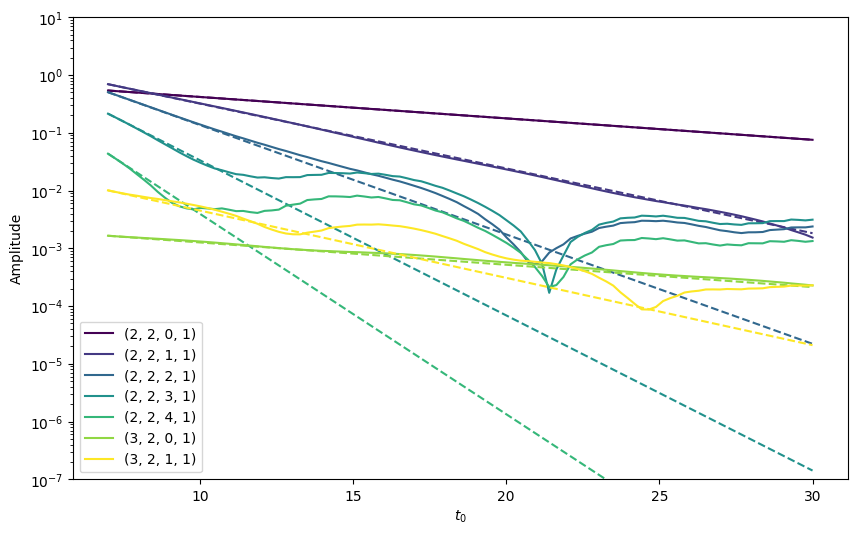

In [ ]:
colours = plt.cm.viridis(np.linspace(0, 1, len(qnm_list)))

fig, ax = plt.subplots(figsize=(10, 6))

for i, qnm in enumerate(qnm_list):
    ax.plot(start_times, np.abs(amplitude_array[:,i]), label=f'{qnm}', color=colours[i])
    ax.plot(start_times, np.abs(peak_amplitudes[i])*np.exp(-omega_list[i].imag*(closest_peak_time - start_times)), linestyle='--', color=colours[i])
ax.set_yscale('log')
ax.set_ylim(1e-7, 1e1)
ax.set_xlabel(r'$t_0$')
ax.set_ylabel('Amplitude')
ax.legend()
plt.show()

### Mode dropping based on amplitude stability

In [79]:
start_times = np.linspace(7, 30, 100)

amplitude_array = np.zeros((len(start_times), len(qnm_list)), dtype=complex)
peak_amplitudes = [] 

ls_fit = qnmfits.ringdown_fit(
    sim_main.times,
    sim_main.h[spherical_mode],
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=peak_time,
    T=T,
)

peak_amplitudes = ls_fit["C"]
omega_list = ls_fit["frequencies"]

In [ ]:
amplitude_array = np.zeros((len(start_times), len(qnm_list)), dtype=complex)

N = n_max
count = 0 

qnm_list_new = qnm_list.copy() 

for i, t0 in enumerate(start_times):

    ls_fit = qnmfits.ringdown_fit(
        sim_main.times,
        sim_main.h[spherical_mode],
        modes=qnm_list_new,
        Mf=Mf_0,
        chif=chif_mag_0,
        t0=t0,
        T=T,
    )

    amplitudes = np.array(ls_fit["C"])
    amplitudes = np.append(amplitudes, 0)

    amplitude_array[i, :] = amplitudes
    expected_amplitude = np.abs(peak_amplitudes[i])*np.exp(-omega_list[N-1].imag*(closest_peak_time - t0))

    if not np.isclose(np.abs(ls_fit['C'][N-1]), expected_amplitude, rtol=1):
        print(f"t0 = {t0} does not match expected amplitude for N = {N}")
        N = N - 1
        count += 1
    
    qnm_list_new.pop()

omega_list = ls_fit["frequencies"]

ValueError: could not broadcast input array from shape (6,) into shape (7,)

In [ ]:
colours = plt.cm.viridis(np.linspace(0, 1, len(qnm_list)))

fig, ax = plt.subplots(figsize=(10, 6))

for i, qnm in enumerate(qnm_list):
    ax.plot(start_times, np.abs(amplitude_array[:,i]), label=f'{qnm}', color=colours[i])
    ax.plot(start_times, np.abs(peak_amplitudes[i])*np.exp(-omega_list[i].imag*(closest_peak_time - start_times)), linestyle='--', color=colours[i])
ax.set_yscale('log')
ax.set_ylim(1e-7, 1e1)
ax.set_xlabel(r'$t_0$')
ax.set_ylabel('Amplitude')
ax.legend()
plt.show()